# Advanced Recommender Systems Lab

This notebook is an implementation of the model iGSLR, a geo-social location recommendation model.

In [ ]:
import pandas as pd
import os
import sys
import numpy as np
from geopy.distance import geodesic 
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
import matplotlib.pyplot as plt
from surprise import AlgoBase
from surprise import PredictionImpossible
from itertools import combinations

## Processing of the dataset

The input dataset for this lab was collected from Gowalla, a popular LBSN that is often used to test recommendation methods with geographical dimensions. In practice the dataset contains user profiles, user friendship, location profiles, and users’ check-in history made before June 1, 2011. It contains 36,001,959 check-ins made by 407,533 users over 2,724,891 locations.

#### Load data

In [ ]:
checkins = pd.read_csv("gowalla_checkins.csv")
friendship = pd.read_csv("gowalla_friendship.csv")
locations = pd.read_csv("gowalla_locations.csv")
userinfo = pd.read_csv("gowalla_userinfo.csv")

#### Filter Data

In [ ]:
checkins_grouped = checkins.groupby('userid',as_index=False).count()
id_checkins_filter = checkins_grouped[(checkins_grouped.placeid >= 5) & (checkins_grouped.placeid <= 50)].userid.values  # get the userid of users who have at least 5 and less than 50 check-ins

checkins_filter = checkins[checkins.userid.isin(id_checkins_filter)]
friendship_filter = friendship[friendship.userid1.isin(id_checkins_filter)]
userinfo_filter = userinfo[userinfo.id.isin(id_checkins_filter)]

#### Compute df_user_friends

Associate for each user the list of his friends.

In [7]:
df_user_friends = friendship_filter.groupby('userid1')['userid2'].apply(list).reset_index(name='friends_list') 
df_user_friends.head()

,userid1,friends_list
0,15,"[256, 578, 2819, 2053110, 136860, 52810, 59307..."
1,37,"[92715, 219, 97751]"
2,45,"[1290, 597, 1567]"
3,53,"[127744, 103943, 161602, 76303, 51728, 127249,..."
4,81,"[69506, 165411, 9767, 9229, 113, 46163, 5044, ..."


#### Compute df_user_locations

Associate for each user the list of the successive locations he visited

In [ ]:
# merge checkins with locations to get the placeid, long and lat for each checkins
checkins_locations = pd.merge(checkins_filter,locations,left_on="placeid",right_on="id",how="left") 
checkins_locations = checkins_locations.dropna(subset = ["placeid","lng","lat"])

df_user_locations = checkins_locations.groupby('userid')['id'].apply(list).reset_index(name='locations_list') 
df_user_locations["lng_lat"] = checkins_locations.groupby('userid')[['lng', 'lat']].apply(lambda x: x.values.tolist()).values # add longitude + latitude

In [9]:
df_user_locations.head()

,userid,locations_list,lng_lat
0,15,"[7198013.0, 9591.0, 8947.0, 1050882.0, 14710.0...","[[-122.4038743973, 37.783129592399995], [-122...."
1,37,"[355154.0, 355396.0, 355356.0, 62846.0, 238753...","[[-118.0491015315, 34.1348080964], [-118.04883..."
2,45,"[7360178.0, 22370.0, 6563736.0, 37303.0, 34157...","[[-117.93418979239999, 33.616031032399995], [-..."
3,53,"[290022.0, 644423.0, 644423.0, 1541920.0, 2900...","[[-118.2852210667, 34.157458383299996], [-118...."
4,81,"[85577.0, 3142623.0, 128873.0, 6708957.0, 6591...","[[-157.9158818722, 21.335531795999998], [-157...."


#### Compute df_frequencies

For each pair (user, location), we compute its corresponding visit frequency.

In [ ]:
df_user_locations_unstack = pd.DataFrame([[i[1], col2] for i in df_user_locations.itertuples() for col2 in i[2]],columns=['userid', 'placeid']) # compute each pair (user,location)
df_user_locations_unstack = df_user_locations_unstack.dropna()
df_frequencies = df_user_locations_unstack.groupby(['userid', 'placeid']).size().reset_index().rename(columns={0:'frequency'})

In [ ]:
fmin = df_frequencies.frequency.min()
fmax = df_frequencies.frequency.max()
df_frequencies["ratings"] = df_frequencies["frequency"].apply(lambda x: 10*np.tanh(10*(x-fmin)/(fmax-fmin))) # update the frequencies into the range [0, 10]

In [12]:
df_frequencies.head()

,userid,placeid,frequency,ratings
0,15,8904.0,1,0.000000
1,15,8947.0,2,2.186351
2,15,9073.0,1,0.000000
3,15,9186.0,1,0.000000
4,15,9591.0,1,0.000000


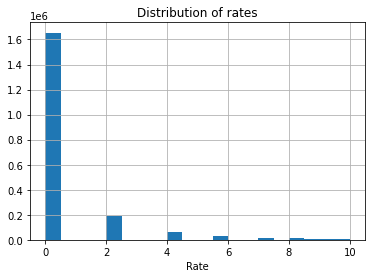

In [13]:
df_frequencies.ratings.hist(bins=20)
plt.xlabel("Rate")
plt.title("Distribution of rates");

#### Train test set split

Load df_frequencies into the Surprise framework to split into a 75% trainset and 25% testset.

In [ ]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_frequencies[['userid', 'placeid', 'ratings']], reader)
trainset, testset = train_test_split(data, test_size=.25)

#### Get Rate

In order to get the rate that a user gives to a location from the trainset surprise, we create a function get_rate. 

In [ ]:
def get_rate(user,location,trainset) : 

    """
    Return the rate that a user gives to a location

    user = id of the user
    location = id of the location
    trainset 

    """

    inner_iid = trainset.to_inner_iid(location) # get the inner id of the location
    inner_uid = trainset.to_inner_uid(user) # get the inner id of the user

    res_ir = trainset.ir[inner_iid] # get rates given for the location
    uid_ir = list(map(lambda x :x[0],res_ir)) 
    rate_ir = list(map(lambda x :x[1],res_ir)) 

    if uid_ir.count(uid_ir) == 1 :
        return rate_ir[uid_ir.index(inner_uid)]

    else : # if the user did not rate the location : 0
        return 0

## Geographical Computations

We create in this part all necessary functions to compute the probability that user u will visit a location.

In [ ]:
def get_pairs(lst) :

    """
    Return the pairs of all elements in the list

    lst = list of placeid

    """

    if len(lst) != 1 :
        return list(combinations(lst,2))

    else :
        return [] # it returns [] if the list only contains one location

In [ ]:
def get_distance(pairs) : 

    """
    Return the distance in km for all pairs

    pairs = list 

    """
    
    dist_list = []

    if pairs != [] :
    
        for pair in pairs :

            # get latitute and longitude for the first element
            lat0 = locations[locations.id == pair[0]].lat.values
            lng0 = locations[locations.id == pair[0]].lng.values

            # get latitute and longitude for the second element
            lat1 = locations[locations.id == pair[1]].lat.values
            lng1 = locations[locations.id == pair[1]].lng.values
            
            # compute distance in km
            dist_list.append(geodesic((lat0,lng0), (lat1,lng1)).km)
        
        return dist_list

    else : # if the list is null
        return []

In [1]:
def compute_geo(user) :

    """
    Return the list of all locations the user has been located to (Lu)
    and the list of distance between each pair of locations (D)

    user = id of the user

    """

    Lu = list(set(df_user_locations[df_user_locations.userid == user].locations_list.values[0]))
    pairs = get_pairs(Lu)
    D = get_distance(pairs)
    
    return Lu,D

In [ ]:
def kernel(x) : 

    """
    Return the normal kernel function with fixed bandwidth

    """

    res = (1/np.sqrt(2*np.pi))*np.exp(-x**2/2)
    
    return res

In [ ]:
def get_density(d,D,Lu) :

    """
    Return the density (equation 2) of any new given distance d

    d = distance
    D = the list of distance between each pair of locations
    Lu = the list of all locations he has been located to

    """

    sigma = np.std(D)
    n = len(Lu)
    h = 1.06*sigma*n**(-1/5)
    D2 = list(map(lambda x : (d-x)/h,D))
    density = 1/(len(D)*h)*sum(list(map(kernel,D2)))

    return density


In [ ]:
def geo_proba(li,Lu,D) :

    """
    Return the empirical mean probability p(li|Lu) of any new location for any given user (equation 3)

    li = [long,lat] of the location
    Lu = the list of all locations he has been located to
    D = the list of distance between each pair of locations

    """

    n = len(Lu)
    d = []

    lat_i = li[1]
    long_i = li[0]

    for l in Lu :

        long_j = locations[locations.id == l].lng.values[0] # get the longitude
        lat_j = locations[locations.id == l].lat.values[0] # get the latitude

        d.append(geodesic((lat_j,long_j), (lat_i,long_i)).km) # compute the distance in km

    density_list = list(map(lambda x : get_density(x,D,Lu),d))

    return np.mean(density_list)

## Social computations

We create in this part all necessary functions to compute the probability p_hat.

In [ ]:
def social_similarity(user_i,user_k) :

    """
    Return the social similarity between user_i and user_k (equation 4)

    user_i, user_k = id of the user

    """
    
    list1 = df_user_friends[df_user_friends.userid1 == user_i].friends_list.values[0] # friends of user_i
    list2 = df_user_friends[df_user_friends.userid1 == user_k].friends_list.values[0] # friends of user_k
    sim = len(list(set(list1) & set(list2))) / len(list(set(list1) | set(list2)))

    return sim

In [ ]:
def user_is_in_trainset(user) :

    """
    Return true if user is in the trainset

    user = id of the user

    """

    try :
        trainset.to_inner_uid(user)
        res = 1
    except :
        res = 0

    return res

In [ ]:
def item_is_in_trainset(item) :

    """
    Return true if item is in the trainset

    item = id of the item

    """

    try :
        trainset.to_inner_iid(item)
        res = 1
    except :
        res = 0

    return res

In [ ]:
def r_hat(user_i,location_j,trainset,F_i) :

    """
    Return r_hat 

    user_i = id of the user
    location_j = id of the location
    trainset
    F_i = list of friends of user_i
    
    """

    rate_j = np.zeros(len(F_i))
    sim_list = np.zeros(len(F_i))

    for i,user in enumerate(F_i) :

        rate_j[i] = get_rate(user,location_j,trainset)
        sim_list[i] = social_similarity(user_i,user)

    return np.dot(sim_list,rate_j) / max(np.sum(sim_list),0.01)

In [ ]:
def p_hat(user_i,location_j,L,trainset,Li) :

    """
    Return p_hat (equation 5)

    user_i = id 
    location_j = id
    L = list of locations in trainset
    Li = the list of all locations user_i has been located to

    """

    L_copy = list(set(L)- set(Li))
    L_copy = [i for i in L_copy if item_is_in_trainset(i)]
    L_copy = L_copy[:500] # reduce the size because of complexity
    F_i = df_user_friends[df_user_friends.userid1 == user_i].friends_list.values[0]
    F_i = [i for i in F_i if user_is_in_trainset(i)]

    if F_i == [] :

        return np.nan

    else :

        numerator = r_hat(user_i,location_j,trainset,F_i)
        denominator = max(max(list(map(lambda x : r_hat(user_i,x,trainset,F_i),L_copy))),0.01)
        
        return numerator/denominator

## Generate and Test Recommendations

We create a new prediction algorithm thanks to the package Surprise. 

In [ ]:
class GSLR(AlgoBase):

    def __init__(self):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)

    def fit(self,trainset):

        AlgoBase.fit(self, trainset)

        self.trainset = trainset

        return self

    def estimate(self, u, i):

        # u = user 
        # i = location 

        # If the user or the location is not in the trainset
        if not (user_is_in_trainset(u) and item_is_in_trainset(i)) :
            print('User and/or item is unkown.')
            return np.nan

        else :

            # compute all the necessary objects to use the function p_hat and geo_proba
            Lu,D = compute_geo(u)
            longi = locations[locations.id == i].lng.values[0] # longitude of the location
            lati = locations[locations.id == i].lat.values[0] # latitude of the location
            li = [longi,lati]
            L = list(np.unique(locations.id))

            res_p_hat = p_hat(u,i,L,self.trainset,Lu)
            res_geo_proba = geo_proba(li,Lu,D)

            if np.isnan(res_p_hat) : # if the user has no friend in the trainset

                score = res_geo_proba # the score is only geo_proba

            else :

                score = (res_p_hat + res_geo_proba) / 2

        return score

In [28]:
model = GSLR()
model.fit(trainset)
predictions = np.zeros(len(testset[:20]))

for i in range(len(testset[:20])) :
    predictions[i] = model.estimate(testset[i][0], testset[i][1]) 
    print("Recommendation score for user ",testset[i][0], "and location ",testset[i][1],": ",predictions[i])

User and/or item is unkown.
Recommendation score for user  2667435 and location  637950.0 :  nan
Recommendation score for user  2269634 and location  257245.0 :  0.0014393013657580502
Recommendation score for user  100958 and location  425510.0 :  0.00011668288624938668
Recommendation score for user  374170 and location  9410.0 :  0.0017498214677857502
User and/or item is unkown.
Recommendation score for user  2474790 and location  7269355.0 :  nan
Recommendation score for user  989323 and location  73825.0 :  0.002595357459826489
User and/or item is unkown.
Recommendation score for user  70633 and location  585102.0 :  nan
User and/or item is unkown.
Recommendation score for user  2080207 and location  6410924.0 :  nan
User and/or item is unkown.
Recommendation score for user  344886 and location  503204.0 :  nan
Recommendation score for user  2140748 and location  1577977.0 :  0.0005881996777316659
Recommendation score for user  13313 and location  43925.0 :  6.655685264068071e-05
Re